In [10]:
#importing relevant packages
import pandas as pd
import numpy as np
import seaborn as sns
from google.cloud import bigquery
from google.oauth2 import service_account
%matplotlib inline

In [11]:
#dictionary with parish names as keys and device ids as values
parish_sensor_dict = {'NTINDA':930434, 'BUGOLOBI':718028, 'NANTABULIRWA':912224, 'KIREKA':930426, 'LUWAFU':930427, 
                     'BANDA':912223, 'MBUYA II':912222, 'NAKASERO II':912220, 'KIWATULE':870145, 'KYALIWAJJALA':870143,
                     'BUTABIKA':870144, 'NANSANA WEST':870147, 'NANSANA EAST':870142, 'BUSEGA':870139, 'KYANJA':832255,
                     'BUSABALA':832252, 'BUNAMWAYA':832253, 'KYEBANDO':832254, 'LUKULI':832251, 'BUKOTO I':782720,
                     'KANSANGA':782719, 'KASUBI':782718, 'NAGURU II':755614, 'MAKINDYE I':755612,
                     'MAKERERE UNIVERSITY':870146, 'LUBAGA':737276, 'BWEYOGERERE':737273, 'CIVIC CENTRE':689761}

In [12]:
def preprocessing(parish):
    '''
    Collects and preprocesses data
    '''
    channel_id = parish_sensor_dict[parish]
    
    #credentials to access GCP
    credentials = service_account.Credentials.from_service_account_file('C:/Users/User/AirQo-d982995f6dd8.json')
    project_id = 'airqo-250220'

    #creating a bigquery cliennt
    bqclient = bigquery.Client(credentials= credentials, project=project_id)
    
    query_string = "SELECT created_at, pm2_5 FROM `airqo-250220.thingspeak.clean_feeds_pms` WHERE channel_id = %d" %channel_id    
    bqdata = bqclient.query(query_string).result()
    data= bqdata.to_dataframe()
    
    data = data.sort_values(by = 'created_at', ascending=True)
    
    #filepath = r'D:/AirQo/sensor location model/feeds/'+str(channel_id)+'.csv'
    #cols = ['created_at', 'field1']
    #data = pd.read_csv(filepath,  parse_dates = ['created_at'], usecols=cols)
    
    data.set_index('created_at', inplace=True)
    hourly_data = data.resample('H').mean().round(2)  
    final_data=hourly_data.dropna()
    
    name = parish+'_pm2_5'
    final_data.rename(columns = {'pm2_5': name}, inplace = True)
    print (parish, ':done')
    
    return final_data

In [13]:
def merge_dfs(df_list):
    '''
    Merges several dataframes into one based on the index
    '''
    from functools import reduce
    final_df = reduce(lambda left,right: pd.merge(left,right,on='created_at'), df_list)
    return final_df

In [14]:
def find_correlation(data, column1, column2):
    '''
    Finds the correlation between 2 different columns in a dataframe
    '''
    correlation = data[column1].corr(data[column2])
    return correlation

In [15]:
def correlation_matrix_1(df):
    return df.corr()

In [16]:
def correlation_matrix_2(df):
    import seaborn as sns
    
    plt.figure(figsize=(5,5))
    sns.heatmap(correlation_matrix_1(df), annot=True, cmap=plt.cm.Reds)
    plt.show()

In [17]:
def correlation_matrix_3(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure(figsize=(5,5))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(correlation_matrix_1(df), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Correlation Matrix')
    fig.colorbar(cax, ticks=[.75,.8,.85,.90,.95,1])
    plt.show()

In [18]:
def correlation_matrix_4(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    f = plt.figure(figsize=(5,5))
    plt.matshow(correlation_matrix_1(df), fignum=f.number)
    plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
    plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16)

In [19]:
data = pd.read_csv('gp_data.csv')
data.shape

(28, 50)

In [20]:
#random sampling
random_samples = data.sample(5)

In [ ]:
random_df_list = []
for parish in random_samples.parish:
    data = preprocessing(parish)
    random_df_list.append(data)

c:\users\user\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


NANSANA EAST :done


In [48]:
merged_df = merge_dfs(random_df_list)
merged_df.head()

,MAKERERE UNIVERSITY_pm2_5,BWEYOGERERE_pm2_5,BUSABALA_pm2_5,KYEBANDO_pm2_5,MBUYA II_pm2_5
created_at,,,,,
2019-11-20 07:00:00+00:00,37.21,48.45,15.28,73.93,36.19
2019-11-20 08:00:00+00:00,40.93,49.26,14.91,70.88,44.54
2019-11-20 09:00:00+00:00,27.93,44.25,6.65,47.11,37.90
2019-11-20 10:00:00+00:00,18.26,32.72,8.32,36.23,24.27
2019-11-20 11:00:00+00:00,13.80,28.45,7.55,173.60,35.35


In [49]:
merged_df.shape

(752, 5)

#### Correlation Matrix

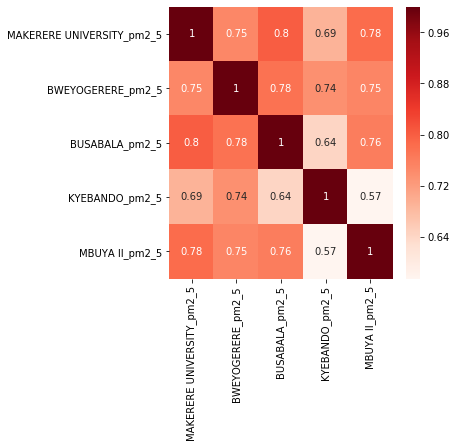

In [63]:
correlation_matrix_2(merged_df)